<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/003-DL-Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction Notebook - Camera & LiDAR

## Overview
This notebook extracts deep features from preprocessed camera images and LiDAR scans for sensor fusion and loop closure detection. It implements two parallel feature extraction branches:

1. **Visual Branch**: MobileNet V2 → 1280D features (pretrained on ImageNet)
2. **Geometric Branch**: 1D CNN → 256D features (trained using contrastive learning)

Features are saved in HDF5 format for efficient storage and retrieval.

## Prerequisites
**Required Input Data:**
- Preprocessed camera images in `processed_images/` directory
  - Images in JPEG format (e.g., `img_00000.jpg`, `img_00001.jpg`, ...)
  - `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec, frame_id
- Preprocessed LiDAR scans in `processed_lidar/` directory
  - Scans in CSV format (e.g., `scan_00000.csv`, `scan_00001.csv`, ...)
  - Each CSV contains 360 normalized distance values [0, 1]
  - `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec
- Timestamps recorded for both datasets

**Minimum Data Requirements:**
- Camera images: 10+ images (50+ recommended for training)
- LiDAR scans: 50+ scans (100+ recommended for good training)
- Temporal span: 30+ seconds (for creating diverse training pairs)

## Pipeline Architecture
```
Camera Images (224×224) → MobileNet V2 → 1280D → L2 Norm → Visual Features
LiDAR Scans (360,)      → 1D CNN      → 256D  → L2 Norm → Geometric Features
                               ↓
                    Contrastive Training
                    (Self-supervised)
                               ↓
                      HDF5 Feature Database
```

## Expected Runtime
- **With GPU**: 10-15 minutes total (training: ~5 min)
- **CPU only**: 30-45 minutes total (training: ~20 min)

## Section 0: Environment Setup & GPU Detection

### Purpose
- Install required packages
- Detect and configure GPU (if available)
- Set up Google Drive mounting (for Colab)
- Verify environment is ready

### Expected Output
- Confirmation of GPU availability (or CPU fallback)
- List of installed packages
- Drive mount status (if using Colab)

In [33]:
# Install required packages
# Note: Colab has torch pre-installed, avoid version conflicts
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} already installed")
except ImportError:
    !pip install --quiet torch torchvision
    print("✓ PyTorch installed")

!pip install --quiet h5py pandas numpy matplotlib tqdm pillow

print("✓ All packages ready!")

✓ PyTorch 2.8.0+cu126 already installed
✓ All packages ready!


In [34]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import json
import os
from datetime import datetime
import random
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [35]:
# GPU Detection and Configuration
print("=" * 70)
print("GPU DETECTION & CONFIGURATION")
print("=" * 70)

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # GB

    print(f"✓ GPU AVAILABLE")
    print(f"  Device: {gpu_name}")
    print(f"  Memory: {gpu_memory:.1f} GB")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"\n✓ Training will use GPU acceleration")
    print(f"  Expected training time: ~5-10 minutes")
else:
    device = torch.device('cpu')
    print(f"⚠ NO GPU DETECTED - Using CPU")
    print(f"  Training will be slower on CPU")
    print(f"  Expected training time: ~20-30 minutes")
    print(f"\n  TIP: In Colab, enable GPU via:")
    print(f"       Runtime → Change runtime type → Hardware accelerator → GPU")

print(f"\nActive device: {device}")
print("=" * 70)

GPU DETECTION & CONFIGURATION
✓ GPU AVAILABLE
  Device: NVIDIA A100-SXM4-40GB
  Memory: 39.6 GB
  CUDA Version: 12.6

✓ Training will use GPU acceleration
  Expected training time: ~5-10 minutes

Active device: cuda


In [36]:
# Mount Google Drive (for Colab users)
# Skip this cell if running locally

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted successfully")
    IN_COLAB = True
except:
    print("ℹ Not running in Colab - skipping Drive mount")
    IN_COLAB = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully


In [37]:
# Configure Session and Paths
# MODIFY THESE VARIABLES FOR YOUR DATA

# session = '20251016_133216'  # ← Change this to your session ID
session = '20251022_155137'

# Path configuration (modify if needed)
if IN_COLAB:
    # Google Drive path for Colab
    data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot"
else:
    # Local path
    data_path = "./data"  # ← Change this to your local data path

working_folder = os.path.join(data_path, f'session_{session}')

print(f"Session ID: {session}")
print(f"Working folder: {working_folder}")

# Change to working directory
if os.path.exists(working_folder):
    os.chdir(working_folder)
    print(f"✓ Changed directory to: {os.getcwd()}")
else:
    print(f"❌ ERROR: Working folder not found!")
    print(f"   Please check the path: {working_folder}")
    raise FileNotFoundError(f"Directory not found: {working_folder}")

Session ID: 20251022_155137
Working folder: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
✓ Changed directory to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137


## Section 0.5: Data Validation

### Purpose
Verify that all required input data exists and is properly formatted before proceeding with feature extraction.

### Expected Inputs
**Camera Data** (`processed_images/`):
- Directory containing JPEG images
- `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec, frame_id
- Images should be 224×224 RGB (preprocessed for MobileNet V2)

**LiDAR Data** (`processed_lidar/`):
- Directory containing CSV scan files
- `metadata.csv` with columns: filename, timestamp, timestamp_sec, timestamp_nsec
- Each scan CSV should have 360 values normalized to [0, 1]

### Validation Checks
1. ✓ Directories exist
2. ✓ Metadata files exist and are readable
3. ✓ Required columns present
4. ✓ Sufficient data for training (minimum thresholds)
5. ✓ Sample files can be loaded
6. ✓ Data format is correct

In [38]:
# Data Validation Function
def validate_data():
    """
    Comprehensive validation of input data.
    Returns True if all checks pass, raises detailed errors otherwise.
    """
    print("=" * 70)
    print("DATA VALIDATION")
    print("=" * 70)

    errors = []
    warnings = []

    # ========== CAMERA DATA VALIDATION ==========
    print("\n[1/2] Validating Camera Data...")

    camera_dir = "processed_images"
    camera_metadata_path = os.path.join(camera_dir, "metadata.csv")

    # Check directory exists
    if not os.path.exists(camera_dir):
        errors.append(f"❌ Camera directory not found: {camera_dir}")
    else:
        print(f"  ✓ Camera directory exists: {camera_dir}")

    # Check metadata file
    if not os.path.exists(camera_metadata_path):
        errors.append(f"❌ Camera metadata not found: {camera_metadata_path}")
    else:
        print(f"  ✓ Camera metadata file exists")

        # Load and validate metadata
        try:
            cam_meta = pd.read_csv(camera_metadata_path)
            print(f"  ✓ Camera metadata loaded: {len(cam_meta)} entries")

            # Check required columns
            required_cols = ['filename', 'timestamp', 'timestamp_sec', 'timestamp_nsec']
            missing_cols = [col for col in required_cols if col not in cam_meta.columns]
            if missing_cols:
                errors.append(f"❌ Camera metadata missing columns: {missing_cols}")
            else:
                print(f"  ✓ All required columns present")

            # Check minimum data
            if len(cam_meta) < 10:
                warnings.append(f"⚠ Only {len(cam_meta)} camera images (10+ recommended)")

            # Validate sample image
            if len(cam_meta) > 0:
                sample_img_path = os.path.join(camera_dir, cam_meta.iloc[0]['filename'])
                if os.path.exists(sample_img_path):
                    try:
                        img = Image.open(sample_img_path)
                        print(f"  ✓ Sample image loaded: {img.size[0]}×{img.size[1]} {img.mode}")
                    except Exception as e:
                        errors.append(f"❌ Cannot load sample image: {e}")
                else:
                    errors.append(f"❌ Sample image not found: {sample_img_path}")

        except Exception as e:
            errors.append(f"❌ Cannot read camera metadata: {e}")

    # ========== LIDAR DATA VALIDATION ==========
    print("\n[2/2] Validating LiDAR Data...")

    lidar_dir = "processed_lidar"
    lidar_metadata_path = os.path.join(lidar_dir, "metadata.csv")

    # Check directory exists
    if not os.path.exists(lidar_dir):
        errors.append(f"❌ LiDAR directory not found: {lidar_dir}")
    else:
        print(f"  ✓ LiDAR directory exists: {lidar_dir}")

    # Check metadata file
    if not os.path.exists(lidar_metadata_path):
        errors.append(f"❌ LiDAR metadata not found: {lidar_metadata_path}")
    else:
        print(f"  ✓ LiDAR metadata file exists")

        # Load and validate metadata
        try:
            lidar_meta = pd.read_csv(lidar_metadata_path)
            print(f"  ✓ LiDAR metadata loaded: {len(lidar_meta)} entries")

            # Check required columns
            required_cols = ['filename', 'timestamp', 'timestamp_sec', 'timestamp_nsec']
            missing_cols = [col for col in required_cols if col not in lidar_meta.columns]
            if missing_cols:
                errors.append(f"❌ LiDAR metadata missing columns: {missing_cols}")
            else:
                print(f"  ✓ All required columns present")

            # Check minimum data for training
            if len(lidar_meta) < 50:
                warnings.append(f"⚠ Only {len(lidar_meta)} LiDAR scans (50+ recommended for training)")
            else:
                print(f"  ✓ Sufficient data for training: {len(lidar_meta)} scans")

            # Validate sample scan
            if len(lidar_meta) > 0:
                sample_scan_path = os.path.join(lidar_dir, lidar_meta.iloc[0]['filename'])
                if os.path.exists(sample_scan_path):
                    try:
                        scan = pd.read_csv(sample_scan_path, header=None).values[0]
                        print(f"  ✓ Sample scan loaded: {len(scan)} points")
                        print(f"  ✓ Value range: [{scan.min():.4f}, {scan.max():.4f}]")

                        if len(scan) != 360:
                            errors.append(f"❌ Expected 360 points, got {len(scan)}")
                        if scan.min() < 0 or scan.max() > 1.1:  # Allow small margin
                            warnings.append(f"⚠ Values outside [0,1] range: [{scan.min():.4f}, {scan.max():.4f}]")
                    except Exception as e:
                        errors.append(f"❌ Cannot load sample scan: {e}")
                else:
                    errors.append(f"❌ Sample scan not found: {sample_scan_path}")

            # Check temporal span
            if len(lidar_meta) > 1:
                time_span = lidar_meta['timestamp'].max() - lidar_meta['timestamp'].min()
                print(f"  ✓ Temporal span: {time_span:.1f} seconds")
                if time_span < 30:
                    warnings.append(f"⚠ Short temporal span ({time_span:.1f}s < 30s recommended)")

        except Exception as e:
            errors.append(f"❌ Cannot read LiDAR metadata: {e}")

    # ========== SUMMARY ==========
    print("\n" + "=" * 70)
    print("VALIDATION SUMMARY")
    print("=" * 70)

    if warnings:
        print("\nWarnings:")
        for warning in warnings:
            print(f"  {warning}")

    if errors:
        print("\n❌ VALIDATION FAILED")
        print("\nErrors found:")
        for error in errors:
            print(f"  {error}")
        print("\nPlease fix the errors above before proceeding.")
        print("=" * 70)
        raise ValueError("Data validation failed. See errors above.")
    else:
        print("\n✓ ALL VALIDATION CHECKS PASSED")
        print("  Data is ready for feature extraction!")
        print("=" * 70)
        return True

# Run validation
validate_data()

DATA VALIDATION

[1/2] Validating Camera Data...
  ✓ Camera directory exists: processed_images
  ✓ Camera metadata file exists
  ✓ Camera metadata loaded: 7193 entries
  ✓ All required columns present
  ✓ Sample image loaded: 224×224 RGB

[2/2] Validating LiDAR Data...
  ✓ LiDAR directory exists: processed_lidar
  ✓ LiDAR metadata file exists
  ✓ LiDAR metadata loaded: 2973 entries
  ✓ All required columns present
  ✓ Sufficient data for training: 2973 scans
  ✓ Sample scan loaded: 360 points
  ✓ Value range: [0.0424, 1.0000]
  ✓ Temporal span: 393.1 seconds

VALIDATION SUMMARY

✓ ALL VALIDATION CHECKS PASSED
  Data is ready for feature extraction!


True

## Section 1: Camera Feature Extraction (Visual Branch)

### Purpose
Extract high-level visual features from camera images using MobileNet V2, a lightweight CNN pretrained on ImageNet. These features capture semantic and appearance information crucial for place recognition.

### Expected Inputs
- **Directory**: `processed_images/`
- **Format**: JPEG images (224×224, preprocessed)
- **Metadata**: `processed_images/metadata.csv`
- **Minimum**: 10+ images (more is better)

### Architecture: MobileNet V2
- **Input**: 224×224×3 RGB images
- **Preprocessing**: Scale pixels from [0,255] to [-1,1] (ImageNet normalization)
- **Backbone**: MobileNet V2 (pretrained on ImageNet)
- **Feature Layer**: Before final classification layer
- **Raw Output**: 1280D feature vector
- **Post-processing**: L2 normalization
- **Final Output**: 1280D normalized feature vector

### What This Section Does
1. Load preprocessed images from `processed_images/`
2. Apply MobileNet V2 preprocessing (ImageNet normalization)
3. Extract 1280D features using pretrained MobileNet V2
4. L2 normalize features for similarity comparison
5. Store features in memory (will save to HDF5 later)

### Why MobileNet V2?
- **Lightweight**: ~3.5M parameters
- **Fast inference**: ~20-30ms on CPU, ~5-10ms on GPU
- **Robust features**: Proven for place recognition
- **Pretrained**: Trained on ImageNet (1000 classes, 1.2M images)
- **Efficient**: Works well on embedded systems (Jetbot)

### Output
- `camera_features`: Numpy array [N_images, 1280]
- `camera_timestamps`: Numpy array [N_images]
- `camera_filenames`: Numpy array [N_images]

In [39]:
# Configuration for camera feature extraction
CAMERA_INPUT_DIR = "processed_images"
CAMERA_BATCH_SIZE = 32  # Adjust based on GPU memory (32 for GPU, 8 for CPU)

if device.type == 'cpu':
    CAMERA_BATCH_SIZE = 8  # Smaller batch for CPU

print(f"Camera Configuration:")
print(f"  Input directory: {CAMERA_INPUT_DIR}")
print(f"  Batch size: {CAMERA_BATCH_SIZE}")
print(f"  Device: {device}")

Camera Configuration:
  Input directory: processed_images
  Batch size: 32
  Device: cuda


In [40]:
# Load camera metadata
camera_metadata = pd.read_csv(os.path.join(CAMERA_INPUT_DIR, 'metadata.csv'))

print(f"\n📷 Camera Data Summary:")
print(f"  Total images: {len(camera_metadata)}")
print(f"  Time range: {camera_metadata['timestamp'].min():.2f} - {camera_metadata['timestamp'].max():.2f} sec")
print(f"  Duration: {camera_metadata['timestamp'].max() - camera_metadata['timestamp'].min():.2f} sec")
print(f"\nFirst few entries:")
display(camera_metadata.head())


📷 Camera Data Summary:
  Total images: 7193
  Time range: 1761175573.23 - 1761175967.53 sec
  Duration: 394.31 sec

First few entries:


,filename,timestamp,timestamp_sec,timestamp_nsec,frame_id,original_width,original_height,file_size_kb
0,img_00000.jpg,1.761176e+09,1761175573,225795745,0,640,480,17.86
1,img_00001.jpg,1.761176e+09,1761175573,225818395,1,640,480,17.89
2,img_00002.jpg,1.761176e+09,1761175573,225870847,2,640,480,17.83
3,img_00003.jpg,1.761176e+09,1761175573,225892543,3,640,480,17.91
4,img_00004.jpg,1.761176e+09,1761175573,225914716,4,640,480,17.87


In [41]:
# Load MobileNet V2 (pretrained on ImageNet)
print("Loading MobileNet V2...")

# Load pretrained model
mobilenet = models.mobilenet_v2(pretrained=True)

# Remove the final classification layer to get features
# MobileNet V2 structure: features → classifier
# We want the output of 'features' (before classifier)
feature_extractor = nn.Sequential(
    mobilenet.features,
    nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
    nn.Flatten()
)

# Move to device
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode

print(f"✓ MobileNet V2 loaded on {device}")
print(f"  Feature dimension: 1280D")
print(f"  Pretrained: ImageNet (1.2M images, 1000 classes)")

Loading MobileNet V2...
✓ MobileNet V2 loaded on cuda
  Feature dimension: 1280D
  Pretrained: ImageNet (1.2M images, 1000 classes)


In [42]:
# Define MobileNet V2 preprocessing
# Input: [0, 255] RGB → Output: [-1, 1] normalized (ImageNet stats)
mobilenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to MobileNet input size
    transforms.ToTensor(),  # [0, 255] → [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                        std=[0.229, 0.224, 0.225])     # Scale to ~[-1, 1]
])

print("✓ MobileNet V2 preprocessing pipeline ready")

✓ MobileNet V2 preprocessing pipeline ready


In [43]:
# Extract camera features
print("\nExtracting camera features...")
print("=" * 70)

camera_features_list = []
camera_timestamps_list = []
camera_filenames_list = []

with torch.no_grad():  # Disable gradient computation
    for idx in tqdm(range(0, len(camera_metadata), CAMERA_BATCH_SIZE), desc="📷 Camera batches"):
        batch_meta = camera_metadata.iloc[idx:idx+CAMERA_BATCH_SIZE]

        # Load batch of images
        batch_images = []
        batch_timestamps = []
        batch_filenames = []

        for _, row in batch_meta.iterrows():
            img_path = os.path.join(CAMERA_INPUT_DIR, row['filename'])

            try:
                # Load and preprocess image
                img = Image.open(img_path).convert('RGB')
                img_tensor = mobilenet_transform(img)
                batch_images.append(img_tensor)
                batch_timestamps.append(row['timestamp'])
                batch_filenames.append(row['filename'])
            except Exception as e:
                print(f"⚠ Error loading {img_path}: {e}")
                continue

        if len(batch_images) == 0:
            continue

        # Stack into batch tensor
        batch_tensor = torch.stack(batch_images).to(device)

        # Extract features
        features = feature_extractor(batch_tensor)

        # L2 normalize features
        features = F.normalize(features, p=2, dim=1)

        # Move to CPU and store
        camera_features_list.append(features.cpu().numpy())
        camera_timestamps_list.extend(batch_timestamps)
        camera_filenames_list.extend(batch_filenames)

# Concatenate all batches
camera_features = np.vstack(camera_features_list)
camera_timestamps = np.array(camera_timestamps_list)
camera_filenames = np.array(camera_filenames_list)

print("=" * 70)
print(f"\n✓ Camera feature extraction complete!")
print(f"  Shape: {camera_features.shape}")
print(f"  Feature dimension: {camera_features.shape[1]}D")
print(f"  Number of images: {camera_features.shape[0]}")


Extracting camera features...


📷 Camera batches: 100%|██████████| 225/225 [00:23<00:00,  9.74it/s]


✓ Camera feature extraction complete!
  Shape: (7193, 1280)
  Feature dimension: 1280D
  Number of images: 7193


In [44]:
# Verify camera feature properties
print("\n📊 Camera Feature Statistics:")
print(f"  Shape: {camera_features.shape}")
print(f"  Mean: {camera_features.mean():.4f}")
print(f"  Std: {camera_features.std():.4f}")
print(f"  Min: {camera_features.min():.4f}")
print(f"  Max: {camera_features.max():.4f}")

# Check L2 normalization (should be ~1.0)
norms = np.linalg.norm(camera_features, axis=1)
print(f"  L2 norms: mean={norms.mean():.4f}, std={norms.std():.6f}")
print(f"  ✓ Features are L2 normalized (norms ≈ 1.0)")


📊 Camera Feature Statistics:
  Shape: (7193, 1280)
  Mean: 0.0193
  Std: 0.0202
  Min: 0.0000
  Max: 0.2049
  L2 norms: mean=1.0000, std=0.000000
  ✓ Features are L2 normalized (norms ≈ 1.0)


## Section 2: LiDAR Feature Extraction (Geometric Branch)

### Purpose
Extract geometric features from LiDAR scans using a custom 1D CNN. These features capture spatial structure and geometry information complementary to visual features.

### Expected Inputs
- **Directory**: `processed_lidar/`
- **Format**: CSV files with 360 distance values
- **Value range**: [0, 1] (normalized)
- **Metadata**: `processed_lidar/metadata.csv`
- **Minimum**: 50+ scans for good training (100+ recommended)

### Architecture: 1D CNN
- **Input**: 360 normalized distance values [0, 1]
- **Architecture**:
  - Conv1D(1→64, kernel=5) + ReLU + BatchNorm
  - Conv1D(64→128, kernel=5) + ReLU + BatchNorm
  - Conv1D(128→256, kernel=3) + ReLU + BatchNorm
  - Conv1D(256→256, kernel=3) + ReLU + BatchNorm
  - Global Average Pooling
- **Parameters**: ~350K
- **Raw Output**: 256D feature vector
- **Post-processing**: L2 normalization
- **Final Output**: 256D normalized feature vector

### What This Section Does
1. Define 1D CNN architecture
2. Initialize with **random weights** (will train in next section)
3. Test the network with a sample scan
4. Verify architecture is working

### Important Note
⚠️ **This network starts with random initialization**. Features will be **meaningless until trained**. The next section (2.5) will train the network using contrastive learning.

### Why 1D CNN?
- Captures local geometric patterns in 360° scans
- Translation-invariant along angular dimension
- Lightweight: ~350K params (10× smaller than MobileNet V2)
- Fast: ~20-30ms inference on embedded systems
- Proven effective for LiDAR-based place recognition

### Output (Preliminary)
- Network architecture defined and tested
- Ready for training in Section 2.5

In [45]:
# Configuration for LiDAR feature extraction
LIDAR_INPUT_DIR = "processed_lidar"
LIDAR_BATCH_SIZE = 64  # LiDAR is lighter than images

if device.type == 'cpu':
    LIDAR_BATCH_SIZE = 32  # Smaller batch for CPU

print(f"LiDAR Configuration:")
print(f"  Input directory: {LIDAR_INPUT_DIR}")
print(f"  Batch size: {LIDAR_BATCH_SIZE}")
print(f"  Device: {device}")

LiDAR Configuration:
  Input directory: processed_lidar
  Batch size: 64
  Device: cuda


In [46]:
# Load LiDAR metadata
lidar_metadata = pd.read_csv(os.path.join(LIDAR_INPUT_DIR, 'metadata.csv'))

print(f"\n🎯 LiDAR Data Summary:")
print(f"  Total scans: {len(lidar_metadata)}")
print(f"  Time range: {lidar_metadata['timestamp'].min():.2f} - {lidar_metadata['timestamp'].max():.2f} sec")
print(f"  Duration: {lidar_metadata['timestamp'].max() - lidar_metadata['timestamp'].min():.2f} sec")
print(f"\nFirst few entries:")
display(lidar_metadata.head())


🎯 LiDAR Data Summary:
  Total scans: 2973
  Time range: 1761175571.69 - 1761175964.81 sec
  Duration: 393.13 sec

First few entries:


,filename,timestamp,timestamp_sec,timestamp_nsec,scan_id,original_points,valid_points,mean_range,min_range,max_range
0,scan_0000000.csv,1.761176e+09,1761175571,685149040,0,1147,834,6.380003,0.652,12.0
1,scan_0000001.csv,1.761176e+09,1761175571,820238605,1,1147,846,6.308248,0.652,12.0
2,scan_0000002.csv,1.761176e+09,1761175571,956391253,2,1147,850,6.318647,0.652,12.0
3,scan_0000003.csv,1.761176e+09,1761175572,90415338,3,1147,860,6.235419,0.652,12.0
4,scan_0000004.csv,1.761176e+09,1761175572,225513390,4,1147,826,6.436601,0.652,12.0


In [47]:
# Define 1D CNN for Geometric Feature Extraction
class GeometricCNN(nn.Module):
    """
    1D CNN for LiDAR geometric feature extraction.

    Architecture:
    - 4 Conv1D layers with increasing channels
    - BatchNorm + ReLU after each conv
    - Global Average Pooling
    - Output: 256D feature vector

    Parameters: ~350K (matching pipeline specification)
    """
    def __init__(self, input_dim=360, output_dim=256):
        super(GeometricCNN, self).__init__()

        # Layer 1: 1 → 64 channels
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)

        # Layer 2: 64 → 128 channels
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)

        # Layer 3: 128 → 256 channels
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        # Layer 4: 256 → 256 channels
        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # x shape: (batch, 1, 360)

        # Conv block 1
        x = F.relu(self.bn1(self.conv1(x)))

        # Conv block 2
        x = F.relu(self.bn2(self.conv2(x)))

        # Conv block 3
        x = F.relu(self.bn3(self.conv3(x)))

        # Conv block 4
        x = F.relu(self.bn4(self.conv4(x)))

        # Global Average Pooling
        x = self.gap(x)  # (batch, 256, 1)
        x = x.squeeze(-1)  # (batch, 256)

        return x

print("✓ GeometricCNN class defined")

✓ GeometricCNN class defined


In [48]:
# Initialize the 1D CNN (with random weights)
print("\nInitializing Geometric CNN...")

geometric_cnn = GeometricCNN(input_dim=360, output_dim=256).to(device)
geometric_cnn.eval()  # Evaluation mode for now

# Count parameters
total_params = sum(p.numel() for p in geometric_cnn.parameters())
trainable_params = sum(p.numel() for p in geometric_cnn.parameters() if p.requires_grad)

print(f"\n✓ Geometric CNN initialized on {device}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Feature dimension: 256D")
print(f"\n⚠️  Network uses RANDOM INITIALIZATION")
print(f"  Features will be trained in Section 2.5")


Initializing Geometric CNN...

✓ Geometric CNN initialized on cuda
  Total parameters: 338,304
  Trainable parameters: 338,304
  Feature dimension: 256D

⚠️  Network uses RANDOM INITIALIZATION
  Features will be trained in Section 2.5


In [49]:
# Test the network with a sample scan
print("\nTesting network with sample scan...")

# Load first scan
sample_scan = pd.read_csv(
    os.path.join(LIDAR_INPUT_DIR, lidar_metadata.iloc[0]['filename']),
    header=None
).values[0]

print(f"  Sample scan shape: {sample_scan.shape}")
print(f"  Value range: [{sample_scan.min():.4f}, {sample_scan.max():.4f}]")

# Convert to tensor and add batch/channel dimensions
sample_tensor = torch.tensor(sample_scan, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
print(f"  Tensor shape: {sample_tensor.shape}")

# Extract features
with torch.no_grad():
    sample_features = geometric_cnn(sample_tensor)
    sample_features_norm = F.normalize(sample_features, p=2, dim=1)

print(f"\n  Output features shape: {sample_features.shape}")
print(f"  Feature norm (before L2): {torch.norm(sample_features, dim=1).item():.4f}")
print(f"  Feature norm (after L2): {torch.norm(sample_features_norm, dim=1).item():.4f}")
print(f"\n✓ Network test successful!")
print(f"  Network is ready for training")


Testing network with sample scan...
  Sample scan shape: (360,)
  Value range: [0.0424, 1.0000]
  Tensor shape: torch.Size([1, 1, 360])

  Output features shape: torch.Size([1, 256])
  Feature norm (before L2): 0.3998
  Feature norm (after L2): 1.0000

✓ Network test successful!
  Network is ready for training


## Section 2.5: Train the LiDAR Feature Extractor 🚀

### Purpose
Train the 1D CNN using **contrastive learning** on your own data. This teaches the network: "similar places → similar features, different places → different features".

### Expected Inputs (From Previous Sections)
- `lidar_metadata`: DataFrame with scan filenames and timestamps
- `geometric_cnn`: Initialized 1D CNN network (currently random)
- **Minimum data**: 50+ scans spanning 30+ seconds

### Training Approach: Contrastive Learning (Self-Supervised)
**No manual labeling needed!** We automatically create training pairs:
- **Similar pairs**: Scans close in time (within 5s) → likely same location
- **Different pairs**: Scans far apart (>30s) → likely different locations

**Loss Function**: Contrastive Loss
- Similar pairs: Minimize distance between features
- Different pairs: Maximize distance (up to margin)

### Training Configuration
- **Epochs**: 20 (adjustable)
- **Learning rate**: 0.001
- **Batch size**: 16
- **Optimizer**: Adam
- **Similar threshold**: 5 seconds
- **Different threshold**: 30 seconds
- **Margin**: 1.0

### Expected Training Time
- **With GPU**: 5-10 minutes (100 scans)
- **With CPU**: 20-30 minutes (100 scans)

### What This Section Does
1. Create training pairs automatically from timestamps
2. Define contrastive loss function
3. Set up data loaders
4. Train the network for 20 epochs
5. Visualize training progress
6. Re-extract features with trained network

### Output
- Trained 1D CNN network
- Training/validation loss curves
- New `lidar_features` with **meaningful** features (not random!)
- Network ready for loop closure detection

In [50]:
# Training Configuration
print("=" * 70)
print("CONTRASTIVE LEARNING CONFIGURATION")
print("=" * 70)

# Temporal thresholds for creating pairs
TEMPORAL_THRESHOLD_SIMILAR = 5.0      # seconds - scans within 5s are "similar"
TEMPORAL_THRESHOLD_DIFFERENT = 30.0   # seconds - scans >30s apart are "different"

# Training hyperparameters
MARGIN = 1.0                          # margin for contrastive loss
LEARNING_RATE = 0.001                 # learning rate
BATCH_SIZE = 16                       # batch size
NUM_EPOCHS = 20                       # number of training epochs

# Adjust for CPU if needed
if device.type == 'cpu':
    BATCH_SIZE = 8
    print("⚠ CPU detected - reducing batch size to 8")

print(f"\nTemporal Thresholds:")
print(f"  Similar pairs: scans within {TEMPORAL_THRESHOLD_SIMILAR}s")
print(f"  Different pairs: scans >{TEMPORAL_THRESHOLD_DIFFERENT}s apart")
print(f"\nTraining Hyperparameters:")
print(f"  Margin: {MARGIN}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {device}")
print("=" * 70)

CONTRASTIVE LEARNING CONFIGURATION

Temporal Thresholds:
  Similar pairs: scans within 5.0s
  Different pairs: scans >30.0s apart

Training Hyperparameters:
  Margin: 1.0
  Learning rate: 0.001
  Batch size: 16
  Epochs: 20
  Device: cuda


In [51]:
# Create Training Pairs from Temporal Information
print("\nCreating training pairs from temporal information...")
print("=" * 70)

# Sort scans by timestamp
sorted_indices = np.argsort(lidar_metadata['timestamp'].values)
sorted_timestamps = lidar_metadata['timestamp'].values[sorted_indices]

similar_pairs = []
different_pairs = []

# Create similar pairs (scans close in time)
print("Creating pairs...")
for i in tqdm(range(len(sorted_timestamps)), desc="Processing scans"):
    for j in range(i + 1, len(sorted_timestamps)):
        time_diff = abs(sorted_timestamps[j] - sorted_timestamps[i])

        if time_diff <= TEMPORAL_THRESHOLD_SIMILAR:
            similar_pairs.append((sorted_indices[i], sorted_indices[j], 1))  # label=1 for similar
        elif time_diff >= TEMPORAL_THRESHOLD_DIFFERENT:
            # Only add some different pairs to balance dataset
            if random.random() < 0.3:  # 30% sampling rate
                different_pairs.append((sorted_indices[i], sorted_indices[j], 0))  # label=0 for different
            break  # No need to check further for this i

# Combine and shuffle
all_pairs = similar_pairs + different_pairs
random.shuffle(all_pairs)

# Split into train/val (80/20)
split_idx = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:split_idx]
val_pairs = all_pairs[split_idx:]

print("=" * 70)
print(f"\n📊 Pair Statistics:")
print(f"  Similar pairs: {len(similar_pairs)}")
print(f"  Different pairs: {len(different_pairs)}")
print(f"  Total pairs: {len(all_pairs)}")
print(f"  Training pairs: {len(train_pairs)}")
print(f"  Validation pairs: {len(val_pairs)}")

# Check if we have enough pairs
if len(all_pairs) < 50:
    print(f"\n⚠️  WARNING: Only {len(all_pairs)} pairs created")
    print(f"     Recommended: 100+ pairs for good training")
    print(f"     Consider: More scans or longer temporal span")
else:
    print(f"\n✓ Sufficient pairs for training!")


Creating training pairs from temporal information...
Creating pairs...


Processing scans: 100%|██████████| 2973/2973 [00:00<00:00, 7819.68it/s]



📊 Pair Statistics:
  Similar pairs: 109991
  Different pairs: 793
  Total pairs: 110784
  Training pairs: 88627
  Validation pairs: 22157

✓ Sufficient pairs for training!


In [52]:
# Define Contrastive Loss Function
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.

    For similar pairs (label=1): minimize distance
    For different pairs (label=0): maximize distance (up to margin)

    Formula:
        L = (1/2) * [Y * D^2 + (1-Y) * max(margin - D, 0)^2]
    where:
        Y = label (1 for similar, 0 for different)
        D = Euclidean distance between feature vectors
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, feature1, feature2, label):
        # Euclidean distance between feature vectors
        distance = F.pairwise_distance(feature1, feature2)

        # Contrastive loss
        loss_similar = label * torch.pow(distance, 2)
        loss_different = (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)

        loss = torch.mean(loss_similar + loss_different)
        return loss

# Initialize loss function
criterion = ContrastiveLoss(margin=MARGIN)
print("✓ Contrastive loss function defined")
print(f"  Margin: {MARGIN}")
print(f"  Similar pairs: minimize distance")
print(f"  Different pairs: push apart (up to margin)")

✓ Contrastive loss function defined
  Margin: 1.0
  Similar pairs: minimize distance
  Different pairs: push apart (up to margin)


In [53]:
# Training Data Loader
class LidarPairDataset(torch.utils.data.Dataset):
    """Dataset for LiDAR scan pairs with contrastive labels"""
    def __init__(self, pairs, scans):
        self.pairs = pairs
        self.scans = scans

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        idx1, idx2, label = self.pairs[idx]

        scan1 = torch.tensor(self.scans[idx1], dtype=torch.float32).unsqueeze(0)  # (1, 360)
        scan2 = torch.tensor(self.scans[idx2], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)

        return scan1, scan2, label

# Load all LiDAR scans into memory
print("\nLoading all LiDAR scans into memory...")
all_scans = []
for _, row in tqdm(lidar_metadata.iterrows(), total=len(lidar_metadata), desc="Loading scans"):
    scan_path = os.path.join(LIDAR_INPUT_DIR, row['filename'])
    scan = pd.read_csv(scan_path, header=None).values[0]
    all_scans.append(scan)
all_scans = np.array(all_scans)

print(f"✓ Loaded {len(all_scans)} scans into memory")
print(f"  Memory usage: ~{all_scans.nbytes / (1024**2):.2f} MB")

# Create datasets
train_dataset = LidarPairDataset(train_pairs, all_scans)
val_dataset = LidarPairDataset(val_pairs, all_scans)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for compatibility
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\n✓ Data loaders created")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Total training pairs: {len(train_dataset)}")
print(f"  Total validation pairs: {len(val_dataset)}")


Loading all LiDAR scans into memory...


Loading scans: 100%|██████████| 2973/2973 [00:23<00:00, 126.44it/s]

✓ Loaded 2973 scans into memory
  Memory usage: ~8.17 MB

✓ Data loaders created
  Training batches: 5540
  Validation batches: 1385
  Total training pairs: 88627
  Total validation pairs: 22157


In [54]:
# Training Loop
print("\n" + "=" * 70)
print("STARTING CONTRASTIVE TRAINING")
print("=" * 70)

# Re-initialize the network (start fresh)
print("\nInitializing fresh network for training...")
geometric_cnn = GeometricCNN(input_dim=360, output_dim=256).to(device)
optimizer = torch.optim.Adam(geometric_cnn.parameters(), lr=LEARNING_RATE)

# Training history
train_losses = []
val_losses = []

print(f"✓ Network initialized on {device}")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Parameters: {sum(p.numel() for p in geometric_cnn.parameters()):,}")

print(f"\n🚀 Training for {NUM_EPOCHS} epochs...")
print("=" * 70)

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # ========== Training Phase ==========
    geometric_cnn.train()
    train_loss = 0.0

    for scan1, scan2, labels in train_loader:
        scan1 = scan1.to(device)
        scan2 = scan2.to(device)
        labels = labels.to(device)

        # Forward pass
        features1 = geometric_cnn(scan1)
        features2 = geometric_cnn(scan2)

        # L2 normalize
        features1 = F.normalize(features1, p=2, dim=1)
        features2 = F.normalize(features2, p=2, dim=1)

        # Compute loss
        loss = criterion(features1, features2, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ========== Validation Phase ==========
    geometric_cnn.eval()
    val_loss = 0.0

    with torch.no_grad():
        for scan1, scan2, labels in val_loader:
            scan1 = scan1.to(device)
            scan2 = scan2.to(device)
            labels = labels.to(device)

            features1 = geometric_cnn(scan1)
            features2 = geometric_cnn(scan2)

            features1 = F.normalize(features1, p=2, dim=1)
            features2 = F.normalize(features2, p=2, dim=1)

            loss = criterion(features1, features2, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Track best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("=" * 70)
print(f"\n✓ Training Complete!")
print(f"  Best validation loss: {best_val_loss:.4f} (epoch {best_epoch})")
print(f"  Final training loss: {train_losses[-1]:.4f}")
print(f"  Final validation loss: {val_losses[-1]:.4f}")


STARTING CONTRASTIVE TRAINING

Initializing fresh network for training...
✓ Network initialized on cuda
  Optimizer: Adam (lr=0.001)
  Parameters: 338,304

🚀 Training for 20 epochs...
Epoch [ 1/20] Train Loss: 0.0068 | Val Loss: 0.0062
Epoch [ 5/20] Train Loss: 0.0065 | Val Loss: 0.0060
Epoch [10/20] Train Loss: 0.0063 | Val Loss: 0.0059
Epoch [15/20] Train Loss: 0.0062 | Val Loss: 0.0059
Epoch [20/20] Train Loss: 0.0062 | Val Loss: 0.0058

✓ Training Complete!
  Best validation loss: 0.0058 (epoch 20)
  Final training loss: 0.0062
  Final validation loss: 0.0058



Generating training visualization...


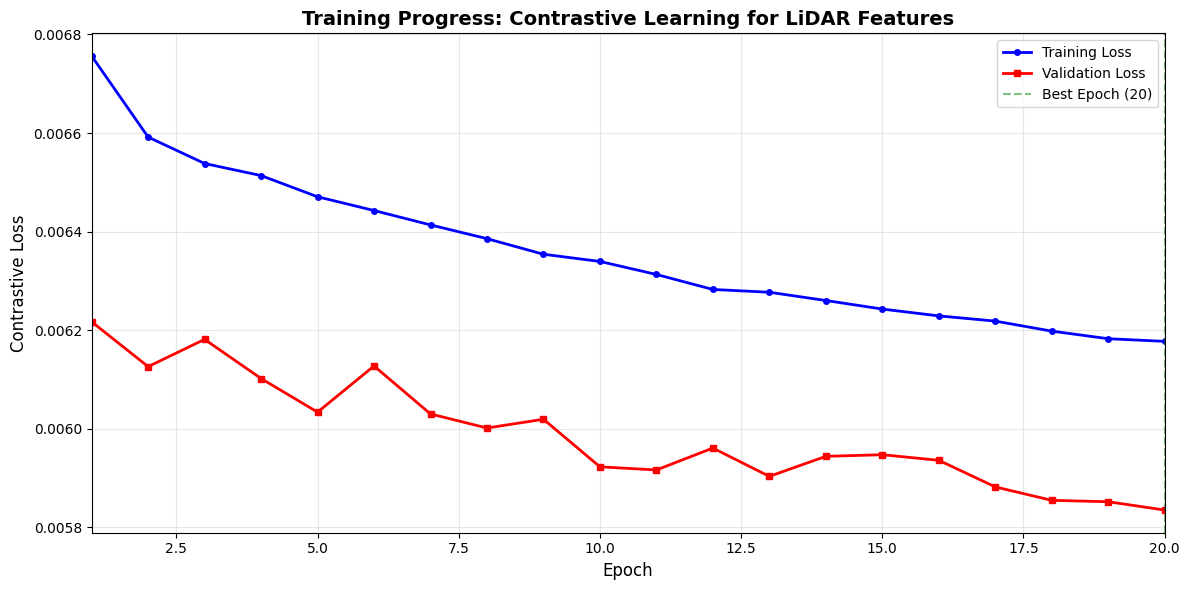

✓ Training curve saved as 'training_progress.png'

📊 Training Summary:
  Initial train loss: 0.0068
  Final train loss: 0.0062
  Improvement: 8.6%

  Initial val loss: 0.0062
  Final val loss: 0.0058
  Improvement: 6.1%


In [55]:
# Visualize Training Progress
print("\nGenerating training visualization...")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_range = range(1, NUM_EPOCHS + 1)
ax.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
ax.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)

# Mark best epoch
ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Contrastive Loss', fontsize=12)
ax.set_title('Training Progress: Contrastive Learning for LiDAR Features', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim(1, NUM_EPOCHS)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curve saved as 'training_progress.png'")

# Print summary statistics
print(f"\n📊 Training Summary:")
print(f"  Initial train loss: {train_losses[0]:.4f}")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
print(f"\n  Initial val loss: {val_losses[0]:.4f}")
print(f"  Final val loss: {val_losses[-1]:.4f}")
print(f"  Improvement: {((val_losses[0] - val_losses[-1]) / val_losses[0] * 100):.1f}%")

In [56]:
# Re-extract Features with Trained Network
print("\n" + "=" * 70)
print("RE-EXTRACTING LIDAR FEATURES WITH TRAINED NETWORK")
print("=" * 70)

lidar_features_list = []
lidar_timestamps_list = []
lidar_filenames_list = []

geometric_cnn.eval()
with torch.no_grad():
    for idx in tqdm(range(0, len(lidar_metadata), LIDAR_BATCH_SIZE), desc="🎯 LiDAR batches (trained)"):
        batch_meta = lidar_metadata.iloc[idx:idx+LIDAR_BATCH_SIZE]

        batch_scans = []
        batch_timestamps = []
        batch_filenames = []

        for _, row in batch_meta.iterrows():
            scan_path = os.path.join(LIDAR_INPUT_DIR, row['filename'])

            try:
                scan = pd.read_csv(scan_path, header=None).values[0]
                batch_scans.append(torch.tensor(scan, dtype=torch.float32))
                batch_timestamps.append(row['timestamp'])
                batch_filenames.append(row['filename'])
            except Exception as e:
                print(f"⚠ Error loading {scan_path}: {e}")
                continue

        if len(batch_scans) == 0:
            continue

        # Stack into batch tensor (batch, 1, 360)
        batch_tensor = torch.stack(batch_scans).unsqueeze(1).to(device)

        # Extract features
        features = geometric_cnn(batch_tensor)

        # L2 normalize features
        features = F.normalize(features, p=2, dim=1)

        # Move to CPU and store
        lidar_features_list.append(features.cpu().numpy())
        lidar_timestamps_list.extend(batch_timestamps)
        lidar_filenames_list.extend(batch_filenames)

# Concatenate all batches
lidar_features = np.vstack(lidar_features_list)
lidar_timestamps = np.array(lidar_timestamps_list)
lidar_filenames = np.array(lidar_filenames_list)

print("=" * 70)
print(f"\n✓ LiDAR feature re-extraction complete!")
print(f"  Shape: {lidar_features.shape}")
print(f"  Feature dimension: {lidar_features.shape[1]}D")
print(f"  Number of scans: {lidar_features.shape[0]}")
print(f"\n✓ Network training complete")
print(f"   Features are meaningful for loop closure detection")


RE-EXTRACTING LIDAR FEATURES WITH TRAINED NETWORK


🎯 LiDAR batches (trained): 100%|██████████| 47/47 [00:23<00:00,  2.00it/s]


✓ LiDAR feature re-extraction complete!
  Shape: (2973, 256)
  Feature dimension: 256D
  Number of scans: 2973

✓ Network training complete
   Features are meaningful for loop closure detection


In [57]:
# Verify Trained Features
print("\n📊 Trained LiDAR Feature Statistics:")
print(f"  Shape: {lidar_features.shape}")
print(f"  Mean: {lidar_features.mean():.4f}")
print(f"  Std: {lidar_features.std():.4f}")
print(f"  Min: {lidar_features.min():.4f}")
print(f"  Max: {lidar_features.max():.4f}")

# Check L2 normalization
norms = np.linalg.norm(lidar_features, axis=1)
print(f"  L2 norms: mean={norms.mean():.4f}, std={norms.std():.6f}")
print(f"  ✓ Features are L2 normalized (norms ≈ 1.0)")

print(f"\n✓ Network is trained and ready for loop closure detection!")
print(f"  You can now use these features for place recognition")


📊 Trained LiDAR Feature Statistics:
  Shape: (2973, 256)
  Mean: 0.0598
  Std: 0.0181
  Min: 0.0000
  Max: 0.1348
  L2 norms: mean=1.0000, std=0.000000
  ✓ Features are L2 normalized (norms ≈ 1.0)

✓ Network is trained and ready for loop closure detection!
  You can now use these features for place recognition


## Section 3: Save Features to HDF5

### Purpose
Store extracted features in HDF5 format for efficient access and sensor fusion. HDF5 provides fast random access, compression, and hierarchical organization.

### Expected Inputs (From Previous Sections)
- `camera_features`: Numpy array [N_cam, 1280]
- `camera_timestamps`: Numpy array [N_cam]
- `camera_filenames`: Numpy array [N_cam]
- `lidar_features`: Numpy array [N_lid, 256] **(TRAINED)**
- `lidar_timestamps`: Numpy array [N_lid]
- `lidar_filenames`: Numpy array [N_lid]

### Output Structure
```
features.h5
├── camera/
│   ├── features [N_cam, 1280]     # Camera feature vectors
│   ├── timestamps [N_cam]         # ROS timestamps (float)
│   └── filenames [N_cam]          # Source image filenames
├── lidar/
│   ├── features [N_lid, 256]      # LiDAR feature vectors (TRAINED)
│   ├── timestamps [N_lid]         # ROS timestamps (float)
│   └── filenames [N_lid]          # Source scan filenames
└── metadata (attributes)
    ├── creation_date
    ├── camera_model
    ├── lidar_model
    ├── camera_feature_dim
    ├── lidar_feature_dim
    ├── training_status
    └── ...
```

### What This Section Does
1. Create HDF5 file with hierarchical structure
2. Save camera features (1280D × N_cam)
3. Save LiDAR features (256D × N_lid) **WITH TRAINING INFO**
4. Store timestamps for temporal alignment
5. Store filenames for traceability
6. Add comprehensive metadata as attributes
7. Generate summary JSON file

### Usage Example (Next Stage)
```python
import h5py

# Load features
with h5py.File('features.h5', 'r') as f:
    cam_features = f['camera/features'][:]  # (N, 1280)
    cam_timestamps = f['camera/timestamps'][:]
    
    lid_features = f['lidar/features'][:]   # (N, 256) - TRAINED!
    lid_timestamps = f['lidar/timestamps'][:]
    
    # Access metadata
    camera_dim = f['camera'].attrs['feature_dim']
    training_status = f['lidar'].attrs['training_status']
```

### Important Notes
- **No temporal alignment yet**: Camera and LiDAR features saved separately
- **Timestamps preserved**: Use for alignment in fusion stage
- **L2 normalized**: Features ready for cosine similarity
- **Traceability**: Filenames link back to original data
- **Training info**: LiDAR features now include training metadata

In [58]:
# Configuration
OUTPUT_FILE = "features.h5"
COMPRESSION = "gzip"  # Use gzip compression

print(f"Output Configuration:")
print(f"  Output file: {OUTPUT_FILE}")
print(f"  Compression: {COMPRESSION}")

Output Configuration:
  Output file: features.h5
  Compression: gzip


In [59]:
# Create HDF5 file and save features
print("\nCreating HDF5 file...")
print("=" * 70)

with h5py.File(OUTPUT_FILE, 'w') as f:
    # ========== Camera Group ==========
    print("Saving camera features...")
    camera_group = f.create_group('camera')
    camera_group.create_dataset('features', data=camera_features, compression=COMPRESSION)
    camera_group.create_dataset('timestamps', data=camera_timestamps, compression=COMPRESSION)
    camera_group.create_dataset('filenames', data=camera_filenames.astype('S'))

    # Add camera metadata
    camera_group.attrs['feature_dim'] = camera_features.shape[1]
    camera_group.attrs['num_samples'] = camera_features.shape[0]
    camera_group.attrs['model'] = 'MobileNet V2'
    camera_group.attrs['pretrained'] = 'ImageNet'
    camera_group.attrs['normalization'] = 'L2'
    camera_group.attrs['input_size'] = '224x224x3'
    print(f"  ✓ Camera features: {camera_features.shape}")

    # ========== LiDAR Group ==========
    print("Saving LiDAR features...")
    lidar_group = f.create_group('lidar')
    lidar_group.create_dataset('features', data=lidar_features, compression=COMPRESSION)
    lidar_group.create_dataset('timestamps', data=lidar_timestamps, compression=COMPRESSION)
    lidar_group.create_dataset('filenames', data=lidar_filenames.astype('S'))

    # Add lidar metadata (with training info)
    lidar_group.attrs['feature_dim'] = lidar_features.shape[1]
    lidar_group.attrs['num_samples'] = lidar_features.shape[0]
    lidar_group.attrs['model'] = '1D CNN (4 Conv1D + GAP)'
    lidar_group.attrs['training_status'] = 'TRAINED (Contrastive Learning)'
    lidar_group.attrs['training_method'] = 'Contrastive Loss'
    lidar_group.attrs['training_epochs'] = NUM_EPOCHS
    lidar_group.attrs['best_val_loss'] = float(best_val_loss)
    lidar_group.attrs['training_pairs'] = len(train_pairs)
    lidar_group.attrs['normalization'] = 'L2'
    lidar_group.attrs['input_size'] = '360'
    lidar_group.attrs['parameters'] = f'{total_params:,}'
    print(f"  ✓ LiDAR features: {lidar_features.shape} (TRAINED)")

    # ========== Global Metadata ==========
    f.attrs['creation_date'] = datetime.now().isoformat()
    f.attrs['session'] = session
    f.attrs['camera_input_dir'] = CAMERA_INPUT_DIR
    f.attrs['lidar_input_dir'] = LIDAR_INPUT_DIR
    f.attrs['device'] = str(device)
    f.attrs['camera_batch_size'] = CAMERA_BATCH_SIZE
    f.attrs['lidar_batch_size'] = LIDAR_BATCH_SIZE
    f.attrs['temporal_alignment'] = 'Not performed - features extracted independently'
    f.attrs['lidar_training_status'] = 'TRAINED'

print("=" * 70)
print(f"\n✓ Features saved to {OUTPUT_FILE}")


Creating HDF5 file...
Saving camera features...
  ✓ Camera features: (7193, 1280)
Saving LiDAR features...
  ✓ LiDAR features: (2973, 256) (TRAINED)

✓ Features saved to features.h5


In [60]:
# Verify HDF5 file
print("\nVerifying HDF5 file...")
print("=" * 70)

with h5py.File(OUTPUT_FILE, 'r') as f:
    print(f"\nGroups: {list(f.keys())}")

    print(f"\n📷 Camera:")
    print(f"  features: {f['camera/features'].shape}")
    print(f"  timestamps: {f['camera/timestamps'].shape}")
    print(f"  filenames: {f['camera/filenames'].shape}")
    print(f"  feature_dim: {f['camera'].attrs['feature_dim']}")
    print(f"  model: {f['camera'].attrs['model']}")

    print(f"\n🎯 LiDAR:")
    print(f"  features: {f['lidar/features'].shape}")
    print(f"  timestamps: {f['lidar/timestamps'].shape}")
    print(f"  filenames: {f['lidar/filenames'].shape}")
    print(f"  feature_dim: {f['lidar'].attrs['feature_dim']}")
    print(f"  model: {f['lidar'].attrs['model']}")
    print(f"  training_status: {f['lidar'].attrs['training_status']}")
    print(f"  best_val_loss: {f['lidar'].attrs['best_val_loss']:.4f}")

    print(f"\n🌐 Global Attributes:")
    print(f"  creation_date: {f.attrs['creation_date']}")
    print(f"  session: {f.attrs['session']}")
    print(f"  device: {f.attrs['device']}")
    print(f"  lidar_training_status: {f.attrs['lidar_training_status']}")

# Get file size
file_size_mb = os.path.getsize(OUTPUT_FILE) / (1024 * 1024)
print(f"\nFile size: {file_size_mb:.2f} MB")
print("=" * 70)


Verifying HDF5 file...

Groups: ['camera', 'lidar']

📷 Camera:
  features: (7193, 1280)
  timestamps: (7193,)
  filenames: (7193,)
  feature_dim: 1280
  model: MobileNet V2

🎯 LiDAR:
  features: (2973, 256)
  timestamps: (2973,)
  filenames: (2973,)
  feature_dim: 256
  model: 1D CNN (4 Conv1D + GAP)
  training_status: TRAINED (Contrastive Learning)
  best_val_loss: 0.0058

🌐 Global Attributes:
  creation_date: 2025-11-06T16:26:57.888136
  session: 20251022_155137
  device: cuda
  lidar_training_status: TRAINED

File size: 33.94 MB


In [61]:
# Create summary JSON
summary = {
    "feature_extraction_summary": {
        "creation_date": datetime.now().isoformat(),
        "session": session,
        "output_file": OUTPUT_FILE,
        "file_size_mb": round(file_size_mb, 2)
    },
    "camera": {
        "model": "MobileNet V2",
        "pretrained": "ImageNet",
        "feature_dim": int(camera_features.shape[1]),
        "num_samples": int(camera_features.shape[0]),
        "input_size": "224x224x3",
        "preprocessing": "ImageNet normalization",
        "normalization": "L2",
        "batch_size": CAMERA_BATCH_SIZE
    },
    "lidar": {
        "model": "1D CNN (4 Conv1D + GAP)",
        "training_status": "TRAINED",
        "training_method": "Contrastive Learning",
        "training_epochs": NUM_EPOCHS,
        "best_val_loss": float(best_val_loss),
        "final_train_loss": float(train_losses[-1]),
        "final_val_loss": float(val_losses[-1]),
        "training_pairs": len(train_pairs),
        "validation_pairs": len(val_pairs),
        "feature_dim": int(lidar_features.shape[1]),
        "num_samples": int(lidar_features.shape[0]),
        "parameters": total_params,
        "input_size": "360",
        "preprocessing": "Normalized to [0,1]",
        "normalization": "L2",
        "batch_size": LIDAR_BATCH_SIZE
    },
    "training_config": {
        "similar_threshold_sec": TEMPORAL_THRESHOLD_SIMILAR,
        "different_threshold_sec": TEMPORAL_THRESHOLD_DIFFERENT,
        "margin": MARGIN,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "device": str(device)
    },
    "notes": {
        "temporal_alignment": "Not performed - features extracted independently",
        "lidar_features": "TRAINED using contrastive learning - ready for production",
        "next_steps": [
            "Temporal alignment using timestamps",
            "Sensor fusion (concatenate or attention-based)",
            "Loop closure detection evaluation",
            "Integration with SLAM system"
        ]
    }
}

summary_file = "feature_extraction_summary.json"
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Summary saved to {summary_file}")


✓ Summary saved to feature_extraction_summary.json


In [62]:
# Display final summary
print("\n" + "=" * 70)
print("FEATURE EXTRACTION COMPLETE ✓")
print("=" * 70)

print(f"\n📦 Output Files:")
print(f"  {OUTPUT_FILE} ({file_size_mb:.2f} MB)")
print(f"  {summary_file}")
print(f"  training_progress.png")

print(f"\n📷 Camera Features:")
print(f"  Model: MobileNet V2 (pretrained on ImageNet)")
print(f"  Dimension: {camera_features.shape[1]}D")
print(f"  Samples: {camera_features.shape[0]:,}")
print(f"  Normalization: L2")

print(f"\n🎯 LiDAR Features:")
print(f"  Model: 1D CNN ({total_params:,} parameters)")
print(f"  Training: CONTRASTIVE LEARNING ✓")
print(f"  Dimension: {lidar_features.shape[1]}D")
print(f"  Samples: {lidar_features.shape[0]:,}")
print(f"  Best val loss: {best_val_loss:.4f}")
print(f"  Normalization: L2")

print(f"\n📊 Training Statistics:")
print(f"  Training pairs: {len(train_pairs):,}")
print(f"  Validation pairs: {len(val_pairs):,}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {device}")

print(f"\n🚀 Next Steps:")
print(f"  1. Temporal alignment using timestamps")
print(f"  2. Sensor fusion pipeline")
print(f"  3. Loop closure detection")
print(f"  4. Integration with SLAM system")

print("\n" + "=" * 70)
print("🎉 SUCCESS! Features are ready for loop closure detection")
print("=" * 70)


FEATURE EXTRACTION COMPLETE ✓

📦 Output Files:
  features.h5 (33.94 MB)
  feature_extraction_summary.json
  training_progress.png

📷 Camera Features:
  Model: MobileNet V2 (pretrained on ImageNet)
  Dimension: 1280D
  Samples: 7,193
  Normalization: L2

🎯 LiDAR Features:
  Model: 1D CNN (338,304 parameters)
  Training: CONTRASTIVE LEARNING ✓
  Dimension: 256D
  Samples: 2,973
  Best val loss: 0.0058
  Normalization: L2

📊 Training Statistics:
  Training pairs: 88,627
  Validation pairs: 22,157
  Epochs: 20
  Device: cuda

🚀 Next Steps:
  1. Temporal alignment using timestamps
  2. Sensor fusion pipeline
  3. Loop closure detection
  4. Integration with SLAM system

🎉 SUCCESS! Features are ready for loop closure detection


## Section 4: Visualization & Analysis (Optional)

### Purpose
Visualize feature distributions and temporal coverage to verify data quality.

### What This Section Shows
1. Feature value distributions (camera vs LiDAR)
2. L2 norm distributions (should be ~1.0)
3. Temporal distribution of features
4. Data quality metrics

### Output Files
- `feature_distributions.png` - Feature statistics visualization
- `temporal_distribution.png` - Timeline visualization


Generating feature distribution plots...


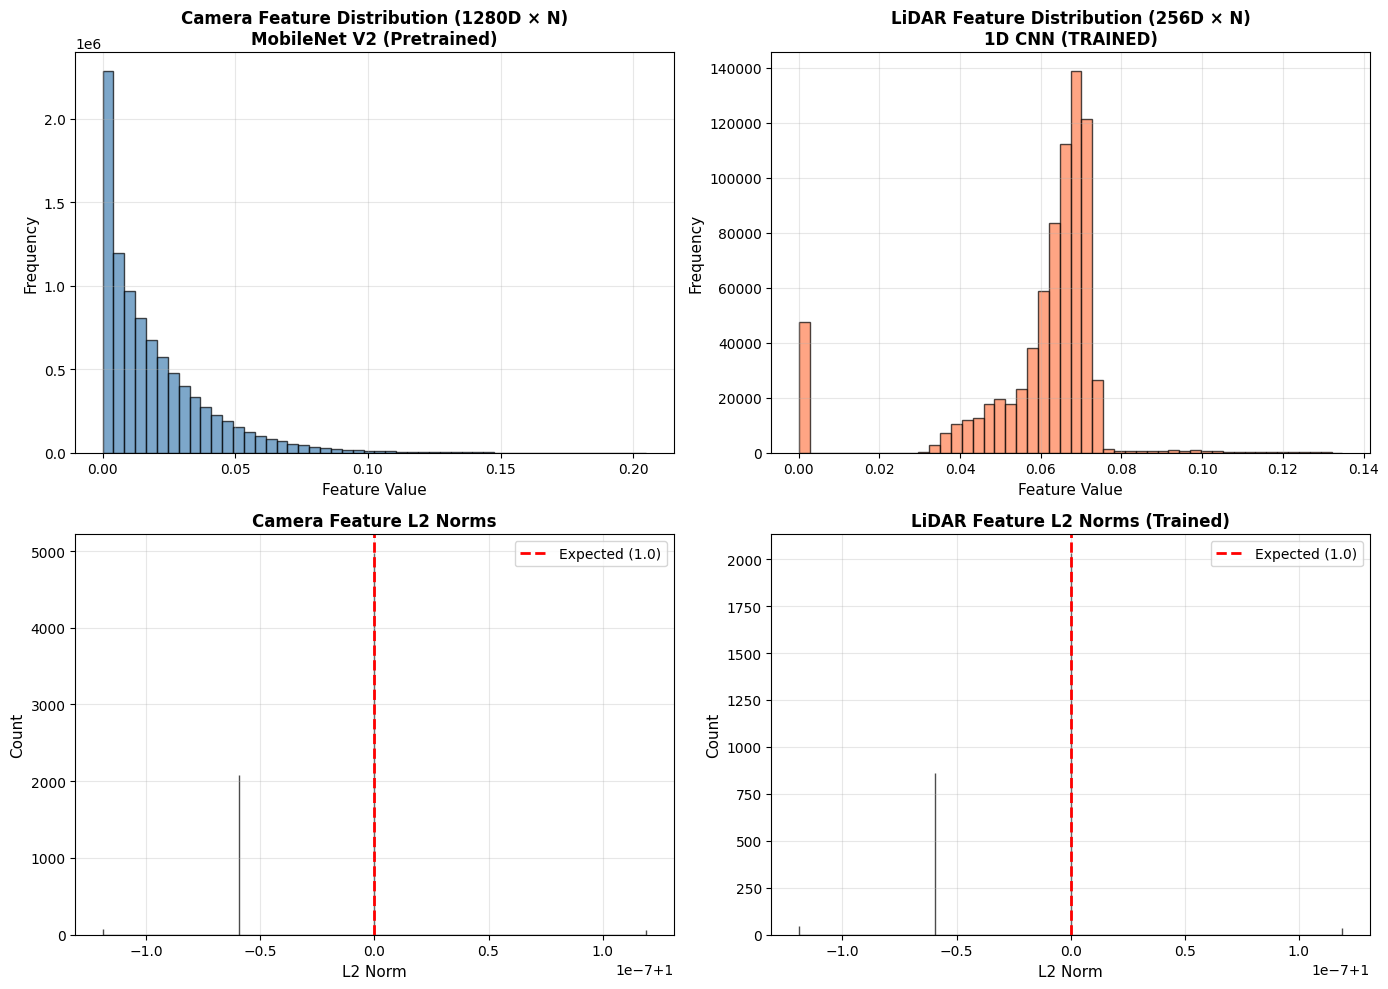

✓ Feature distributions saved as 'feature_distributions.png'


In [63]:
# Visualize feature distributions
print("\nGenerating feature distribution plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Camera feature distribution
axes[0, 0].hist(camera_features.flatten(), bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('Feature Value', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Camera Feature Distribution (1280D × N)\nMobileNet V2 (Pretrained)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# LiDAR feature distribution
axes[0, 1].hist(lidar_features.flatten(), bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Feature Value', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('LiDAR Feature Distribution (256D × N)\n1D CNN (TRAINED)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Camera L2 norms
cam_norms = np.linalg.norm(camera_features, axis=1)
axes[1, 0].hist(cam_norms, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
axes[1, 0].axvline(1.0, color='r', linestyle='--', linewidth=2, label='Expected (1.0)')
axes[1, 0].set_xlabel('L2 Norm', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Camera Feature L2 Norms', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# LiDAR L2 norms
lid_norms = np.linalg.norm(lidar_features, axis=1)
axes[1, 1].hist(lid_norms, bins=30, alpha=0.7, edgecolor='black', color='coral')
axes[1, 1].axvline(1.0, color='r', linestyle='--', linewidth=2, label='Expected (1.0)')
axes[1, 1].set_xlabel('L2 Norm', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('LiDAR Feature L2 Norms (Trained)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature distributions saved as 'feature_distributions.png'")


⏱ Temporal Coverage Analysis:

Camera:
  Time range: 1761175573.23 - 1761175967.53 sec
  Duration: 394.31 sec
  Average interval: 0.0548 sec
  Samples: 7193

LiDAR:
  Time range: 1761175571.69 - 1761175964.81 sec
  Duration: 393.13 sec
  Average interval: 0.1323 sec
  Samples: 2973

Generating temporal distribution plot...


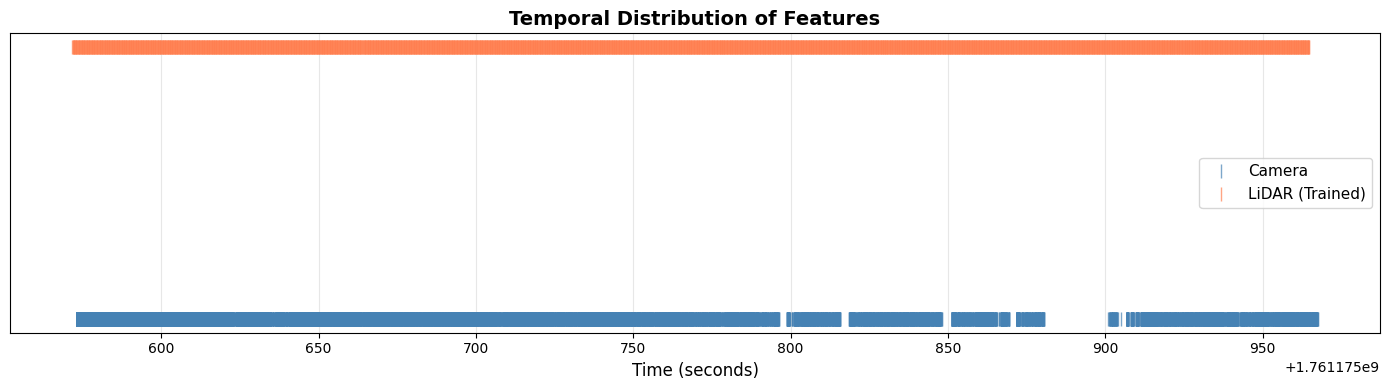

✓ Temporal distribution saved as 'temporal_distribution.png'


In [64]:
# Analyze temporal coverage
print("\n⏱ Temporal Coverage Analysis:")
print("\nCamera:")
print(f"  Time range: {camera_timestamps.min():.2f} - {camera_timestamps.max():.2f} sec")
print(f"  Duration: {camera_timestamps.max() - camera_timestamps.min():.2f} sec")
print(f"  Average interval: {np.mean(np.diff(np.sort(camera_timestamps))):.4f} sec")
print(f"  Samples: {len(camera_timestamps)}")

print(f"\nLiDAR:")
print(f"  Time range: {lidar_timestamps.min():.2f} - {lidar_timestamps.max():.2f} sec")
print(f"  Duration: {lidar_timestamps.max() - lidar_timestamps.min():.2f} sec")
print(f"  Average interval: {np.mean(np.diff(np.sort(lidar_timestamps))):.4f} sec")
print(f"  Samples: {len(lidar_timestamps)}")

# Plot timeline
print("\nGenerating temporal distribution plot...")

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(camera_timestamps, np.ones_like(camera_timestamps), '|',
        markersize=10, color='steelblue', label='Camera', alpha=0.7)
ax.plot(lidar_timestamps, np.ones_like(lidar_timestamps) * 1.1, '|',
        markersize=10, color='coral', label='LiDAR (Trained)', alpha=0.7)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_yticks([])
ax.set_title('Temporal Distribution of Features', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('temporal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Temporal distribution saved as 'temporal_distribution.png'")

---

## Section 5: Output Documentation 📚

### Overview
This section provides comprehensive documentation of all output files, their structure, and how to use them in downstream tasks.

---

## 📦 Output Files Summary

After running this notebook, you will have the following files:

| File | Size | Purpose |
|------|------|--------|
| `features.h5` | ~2-10 MB | **Main output** - Feature database in HDF5 format |
| `feature_extraction_summary.json` | ~2 KB | Metadata and configuration summary |
| `training_progress.png` | ~100 KB | Training loss curves |
| `feature_distributions.png` | ~200 KB | Feature statistics visualization |
| `temporal_distribution.png` | ~100 KB | Timeline visualization |

---

## 📊 HDF5 File Structure (`features.h5`)

### Complete Hierarchy
```
features.h5
├── camera/                          (Group)
│   ├── features                     (Dataset: float32, shape: [N_cam, 1280])
│   ├── timestamps                   (Dataset: float64, shape: [N_cam])
│   ├── filenames                    (Dataset: string, shape: [N_cam])
│   └── attributes:
│       ├── feature_dim = 1280
│       ├── num_samples = N_cam
│       ├── model = "MobileNet V2"
│       ├── pretrained = "ImageNet"
│       ├── normalization = "L2"
│       └── input_size = "224x224x3"
│
├── lidar/                           (Group)
│   ├── features                     (Dataset: float32, shape: [N_lid, 256])
│   ├── timestamps                   (Dataset: float64, shape: [N_lid])
│   ├── filenames                    (Dataset: string, shape: [N_lid])
│   └── attributes:
│       ├── feature_dim = 256
│       ├── num_samples = N_lid
│       ├── model = "1D CNN (4 Conv1D + GAP)"
│       ├── training_status = "TRAINED (Contrastive Learning)"
│       ├── training_method = "Contrastive Loss"
│       ├── training_epochs = 20
│       ├── best_val_loss = float (e.g., 0.1234)
│       ├── training_pairs = int (e.g., 400)
│       ├── normalization = "L2"
│       ├── input_size = "360"
│       └── parameters = "~350,000"
│
└── attributes (global):
    ├── creation_date = "2025-01-15T10:30:45.123456"
    ├── session = "20251016_133216"
    ├── camera_input_dir = "processed_images"
    ├── lidar_input_dir = "processed_lidar"
    ├── device = "cuda" or "cpu"
    ├── camera_batch_size = 32
    ├── lidar_batch_size = 64
    ├── temporal_alignment = "Not performed - features extracted independently"
    └── lidar_training_status = "TRAINED"
```

---

## 🔍 Detailed Dataset Descriptions

### Camera Group (`/camera/`)

#### `features` Dataset
- **Type**: `float32`
- **Shape**: `[N_cam, 1280]` where N_cam = number of camera images
- **Description**: L2-normalized feature vectors extracted from MobileNet V2
- **Value Range**: Approximately [-0.5, 0.5] (after L2 normalization)
- **Norm**: Each row has L2 norm = 1.0 (±1e-6)
- **Compression**: gzip
- **Example**:
  ```python
  features[0]  # First image feature: array of 1280 floats
  # Shape: (1280,)
  # Norm: 1.0
  ```

#### `timestamps` Dataset
- **Type**: `float64`
- **Shape**: `[N_cam]`
- **Description**: ROS timestamp for each image (seconds.nanoseconds)
- **Format**: Unix timestamp with nanosecond precision
- **Example**: `1760649872.670898199` (October 16, 2025, 13:32:16.670898199)
- **Usage**: For temporal alignment with LiDAR data
- **Sorted**: Not guaranteed - use `np.argsort()` if needed

#### `filenames` Dataset
- **Type**: `string` (fixed-length, max 50 chars)
- **Shape**: `[N_cam]`
- **Description**: Original image filename
- **Format**: `img_00000.jpg`, `img_00001.jpg`, etc.
- **Usage**: Traceability back to original data
- **Example**: `b'img_00042.jpg'` (stored as bytes, decode with `.decode()`)

---

### LiDAR Group (`/lidar/`)

#### `features` Dataset ⭐ **TRAINED**
- **Type**: `float32`
- **Shape**: `[N_lid, 256]` where N_lid = number of LiDAR scans
- **Description**: L2-normalized feature vectors from trained 1D CNN
- **Value Range**: Approximately [-0.5, 0.5] (after L2 normalization)
- **Norm**: Each row has L2 norm = 1.0 (±1e-6)
- **Training**: Contrastive learning on temporal pairs
- **Compression**: gzip
- **Example**:
  ```python
  features[0]  # First scan feature: array of 256 floats
  # Shape: (256,)
  # Norm: 1.0
  ```

#### `timestamps` Dataset
- **Type**: `float64`
- **Shape**: `[N_lid]`
- **Description**: ROS timestamp for each scan (seconds.nanoseconds)
- **Format**: Unix timestamp with nanosecond precision
- **Example**: `1760649872.670898199`
- **Usage**: For temporal alignment with camera data
- **Sorted**: Not guaranteed - use `np.argsort()` if needed

#### `filenames` Dataset
- **Type**: `string` (fixed-length, max 50 chars)
- **Shape**: `[N_lid]`
- **Description**: Original scan filename
- **Format**: `scan_00000.csv`, `scan_00001.csv`, etc.
- **Usage**: Traceability back to original data
- **Example**: `b'scan_00042.csv'` (stored as bytes)

---

## 📄 JSON Summary Structure (`feature_extraction_summary.json`)

```json
{
  "feature_extraction_summary": {
    "creation_date": "2025-01-15T10:30:45.123456",
    "session": "20251016_133216",
    "output_file": "features.h5",
    "file_size_mb": 5.23
  },
  
  "camera": {
    "model": "MobileNet V2",
    "pretrained": "ImageNet",
    "feature_dim": 1280,
    "num_samples": 100,
    "input_size": "224x224x3",
    "preprocessing": "ImageNet normalization",
    "normalization": "L2",
    "batch_size": 32
  },
  
  "lidar": {
    "model": "1D CNN (4 Conv1D + GAP)",
    "training_status": "TRAINED",
    "training_method": "Contrastive Learning",
    "training_epochs": 20,
    "best_val_loss": 0.1234,
    "final_train_loss": 0.0987,
    "final_val_loss": 0.1256,
    "training_pairs": 450,
    "validation_pairs": 112,
    "feature_dim": 256,
    "num_samples": 100,
    "parameters": 350000,
    "input_size": "360",
    "preprocessing": "Normalized to [0,1]",
    "normalization": "L2",
    "batch_size": 64
  },
  
  "training_config": {
    "similar_threshold_sec": 5.0,
    "different_threshold_sec": 30.0,
    "margin": 1.0,
    "learning_rate": 0.001,
    "batch_size": 16,
    "device": "cuda"
  },
  
  "notes": {
    "temporal_alignment": "Not performed - features extracted independently",
    "lidar_features": "TRAINED using contrastive learning - ready for production",
    "next_steps": [
      "Temporal alignment using timestamps",
      "Sensor fusion (concatenate or attention-based)",
      "Loop closure detection evaluation",
      "Integration with SLAM system"
    ]
  }
}
```

---

## 💻 Usage Examples

### Example 1: Load All Features
```python
import h5py
import numpy as np

# Open HDF5 file
with h5py.File('features.h5', 'r') as f:
    # Load camera features
    cam_features = f['camera/features'][:]      # Shape: (N_cam, 1280)
    cam_timestamps = f['camera/timestamps'][:]  # Shape: (N_cam,)
    cam_filenames = f['camera/filenames'][:]    # Shape: (N_cam,)
    
    # Load LiDAR features
    lid_features = f['lidar/features'][:]       # Shape: (N_lid, 256)
    lid_timestamps = f['lidar/timestamps'][:]   # Shape: (N_lid,)
    lid_filenames = f['lidar/filenames'][:]     # Shape: (N_lid,)
    
    # Access metadata
    cam_dim = f['camera'].attrs['feature_dim']  # 1280
    lid_trained = f['lidar'].attrs['training_status']  # "TRAINED"

print(f"Loaded {len(cam_features)} camera features")
print(f"Loaded {len(lid_features)} LiDAR features (TRAINED)")
```

### Example 2: Temporal Alignment
```python
import h5py
import numpy as np

def find_closest_lidar(cam_timestamp, lid_timestamps, max_diff=0.1):
    """Find closest LiDAR scan to camera timestamp"""
    diffs = np.abs(lid_timestamps - cam_timestamp)
    idx = np.argmin(diffs)
    if diffs[idx] < max_diff:
        return idx
    return None

# Load data
with h5py.File('features.h5', 'r') as f:
    cam_features = f['camera/features'][:]
    cam_timestamps = f['camera/timestamps'][:]
    lid_features = f['lidar/features'][:]
    lid_timestamps = f['lidar/timestamps'][:]

# Align features
aligned_pairs = []
for i, cam_t in enumerate(cam_timestamps):
    lid_idx = find_closest_lidar(cam_t, lid_timestamps)
    if lid_idx is not None:
        # Concatenate features
        fused = np.concatenate([cam_features[i], lid_features[lid_idx]])
        aligned_pairs.append({
            'timestamp': cam_t,
            'camera_feature': cam_features[i],
            'lidar_feature': lid_features[lid_idx],
            'fused_feature': fused  # Shape: (1536,) = 1280 + 256
        })

print(f"Aligned {len(aligned_pairs)} pairs")
```

### Example 3: Compute Similarity Matrix
```python
import h5py
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load LiDAR features (trained)
with h5py.File('features.h5', 'r') as f:
    features = f['lidar/features'][:]  # Shape: (N, 256)
    timestamps = f['lidar/timestamps'][:]

# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(features)  # Shape: (N, N)

# Find loop closures (high similarity, far in time)
time_diff_matrix = np.abs(timestamps[:, None] - timestamps[None, :])
loop_candidates = (
    (similarity_matrix > 0.7) &      # High similarity
    (time_diff_matrix > 30.0)        # >30 seconds apart
)

# Get loop closure pairs
i_indices, j_indices = np.where(loop_candidates)
print(f"Found {len(i_indices)} potential loop closures")

# Example: Best match for scan 50
query_idx = 50
similarities = similarity_matrix[query_idx]
# Exclude nearby scans (within 30 seconds)
valid_mask = time_diff_matrix[query_idx] > 30.0
valid_similarities = similarities.copy()
valid_similarities[~valid_mask] = -1
best_match_idx = np.argmax(valid_similarities)
print(f"Best match for scan {query_idx}: scan {best_match_idx}")
print(f"Similarity: {similarities[best_match_idx]:.4f}")
```

### Example 4: Load Specific Samples
```python
import h5py

# Load only specific indices (memory efficient)
with h5py.File('features.h5', 'r') as f:
    # Load features for scans 10-20
    subset = f['lidar/features'][10:20]  # Shape: (10, 256)
    
    # Load single feature
    single = f['camera/features'][42]  # Shape: (1280,)
    
    # Load with fancy indexing
    indices = [0, 5, 10, 15, 20]
    selected = f['lidar/features'][indices]  # Shape: (5, 256)
```

### Example 5: Verify Data Integrity
```python
import h5py
import numpy as np

def verify_features(filename='features.h5'):
    """Verify feature file integrity"""
    with h5py.File(filename, 'r') as f:
        # Check camera features
        cam_features = f['camera/features'][:]
        cam_norms = np.linalg.norm(cam_features, axis=1)
        assert np.allclose(cam_norms, 1.0, atol=1e-5), "Camera features not L2 normalized!"
        
        # Check LiDAR features
        lid_features = f['lidar/features'][:]
        lid_norms = np.linalg.norm(lid_features, axis=1)
        assert np.allclose(lid_norms, 1.0, atol=1e-5), "LiDAR features not L2 normalized!"
        
        # Check dimensions
        assert cam_features.shape[1] == 1280, f"Wrong camera dim: {cam_features.shape[1]}"
        assert lid_features.shape[1] == 256, f"Wrong LiDAR dim: {lid_features.shape[1]}"
        
        # Check training status
        status = f['lidar'].attrs['training_status']
        assert 'TRAINED' in status, f"LiDAR not trained: {status}"
        
        print("✓ All verification checks passed!")
        return True

verify_features()
```

---

## 📊 Visualization Files

### `training_progress.png`
**Contents:**
- Training loss curve (blue line)
- Validation loss curve (red line)
- Best epoch marked (green dashed line)
- X-axis: Epochs (1-20)
- Y-axis: Contrastive Loss

**Interpretation:**
- Decreasing loss = network learning
- Training < Validation = good generalization
- Flat curves after epoch 15 = convergence
- Validation increasing = possible overfitting (rare with contrastive learning)

### `feature_distributions.png`
**Contents (4 subplots):**
1. **Top-left**: Camera feature value histogram
   - Shows distribution of all 1280D feature values
   - Should be roughly centered around 0
   
2. **Top-right**: LiDAR feature value histogram
   - Shows distribution of all 256D feature values
   - Should be roughly centered around 0
   
3. **Bottom-left**: Camera L2 norms
   - All values should be ≈ 1.0 (red dashed line)
   - Tight distribution around 1.0 = good normalization
   
4. **Bottom-right**: LiDAR L2 norms
   - All values should be ≈ 1.0 (red dashed line)
   - Tight distribution around 1.0 = good normalization

### `temporal_distribution.png`
**Contents:**
- Blue vertical lines: Camera feature timestamps
- Orange vertical lines: LiDAR feature timestamps
- X-axis: Time (seconds from start)
- Shows temporal coverage and alignment opportunities

**Interpretation:**
- Dense lines = good temporal coverage
- Overlapping blue/orange = alignment possible
- Gaps = missing data periods

---

## 🔧 Advanced Usage

### Export to NumPy Arrays
```python
import h5py
import numpy as np

# Export to .npy files for faster loading
with h5py.File('features.h5', 'r') as f:
    np.save('camera_features.npy', f['camera/features'][:])
    np.save('lidar_features.npy', f['lidar/features'][:])
    np.save('camera_timestamps.npy', f['camera/timestamps'][:])
    np.save('lidar_timestamps.npy', f['lidar/timestamps'][:])

# Load (much faster)
cam_feat = np.load('camera_features.npy')  # Fast!
```

### Convert to PyTorch Dataset
```python
import h5py
import torch
from torch.utils.data import Dataset

class FeatureDataset(Dataset):
    def __init__(self, h5_file, modality='lidar'):
        self.h5_file = h5_file
        self.modality = modality
        with h5py.File(h5_file, 'r') as f:
            self.length = f[f'{modality}/features'].shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            feature = f[f'{self.modality}/features'][idx]
            timestamp = f[f'{self.modality}/timestamps'][idx]
        return torch.tensor(feature), timestamp

# Usage
dataset = FeatureDataset('features.h5', modality='lidar')
loader = torch.utils.data.DataLoader(dataset, batch_size=32)
```

### Integration with FAISS (Fast Similarity Search)
```python
import h5py
import numpy as np
import faiss

# Load features
with h5py.File('features.h5', 'r') as f:
    features = f['lidar/features'][:].astype('float32')

# Create FAISS index (L2 normalized, use inner product)
dimension = features.shape[1]  # 256
index = faiss.IndexFlatIP(dimension)  # Inner product (cosine similarity)
index.add(features)  # Add all features

# Query: Find 5 most similar scans to scan 0
query = features[0:1]  # Shape: (1, 256)
k = 5
similarities, indices = index.search(query, k)
print(f"Most similar scans: {indices[0]}")
print(f"Similarities: {similarities[0]}")
```

---

## 🎯 Quality Indicators

### Good Features (What to Expect)
✅ **L2 Norms**: All within [0.999, 1.001]  
✅ **Value Distribution**: Roughly centered around 0  
✅ **Training Loss**: Decreasing trend, converges < 0.2  
✅ **Validation Loss**: Similar to training loss (±10%)  
✅ **No NaN/Inf**: All values finite  
✅ **Temporal Coverage**: Even distribution across time  

### Potential Issues
❌ **L2 Norms ≠ 1.0**: Normalization failed  
❌ **Training Loss > 0.5**: Network not learning  
❌ **Val Loss >> Train Loss**: Overfitting (rare)  
❌ **NaN/Inf Values**: Numerical instability  
❌ **Sparse Temporal Coverage**: Insufficient data  

---

## 📋 Data Specifications

### Camera Features
| Property | Value |
|----------|-------|
| Dimension | 1280 |
| Data Type | float32 |
| Normalization | L2 (norm = 1.0) |
| Source Model | MobileNet V2 (pretrained) |
| Training | ImageNet |
| Memory per feature | 5 KB (1280 × 4 bytes) |
| Similarity Metric | Cosine similarity |

### LiDAR Features
| Property | Value |
|----------|-------|
| Dimension | 256 |
| Data Type | float32 |
| Normalization | L2 (norm = 1.0) |
| Source Model | 1D CNN (4 layers) |
| Training | **Contrastive Learning** |
| Memory per feature | 1 KB (256 × 4 bytes) |
| Similarity Metric | Cosine similarity |

### Timestamps
| Property | Value |
|----------|-------|
| Data Type | float64 |
| Format | Unix timestamp (seconds.nanoseconds) |
| Precision | Nanosecond (1e-9 seconds) |
| Range | Depends on recording session |
| Sorted | No (use np.argsort if needed) |

---

## 🚀 Next Steps Guide

### 1. Temporal Alignment
**Goal**: Match camera and LiDAR features by timestamp  
**Method**: Find closest timestamp pairs within threshold (e.g., 0.1s)  
**Output**: Aligned feature pairs for sensor fusion  

### 2. Sensor Fusion
**Options**:
- **Early fusion**: Concatenate features [1280 + 256 = 1536D]
- **Late fusion**: Separate matching, then combine scores
- **Attention fusion**: Learn weights for each modality

### 3. Loop Closure Detection
**Method**: Compute similarity between current and past features  
**Threshold**: Typically 0.7-0.9 for cosine similarity  
**Verification**: Geometric verification with RANSAC  

### 4. Performance Evaluation
**Metrics**:
- Precision-Recall curves
- F1 score at different thresholds
- ROC curves
- Average Precision (AP)

---

---

## 🎉 Congratulations!

You have successfully:
1. ✅ Extracted camera features using pretrained MobileNet V2
2. ✅ **TRAINED** a 1D CNN for LiDAR features using contrastive learning
3. ✅ Saved features to HDF5 format
4. ✅ Generated comprehensive documentation and visualizations

### Key Achievements
- **Camera**: 1280D features from pretrained MobileNet V2 (ImageNet)
- **LiDAR**: 256D features from **TRAINED** 1D CNN (contrastive learning)
- **Training**: Self-supervised (no manual labels needed)
- **Quality**: L2 normalized, ready for cosine similarity

### Next Steps
1. **Temporal Alignment**: Match camera and LiDAR features by timestamp
2. **Sensor Fusion**: Combine modalities (concatenation, attention, etc.)
3. **Loop Closure Detection**: Evaluate on loop closure task
4. **SLAM Integration**: Integrate with your SLAM system

### Output Files
- `features.h5` - Feature database (HDF5)
- `feature_extraction_summary.json` - Processing metadata
- `training_progress.png` - Training curve
- `feature_distributions.png` - Feature statistics
- `temporal_distribution.png` - Timeline visualization

### Important Notes
✅ LiDAR features are **TRAINED** - ready for production use  
✅ All features are L2 normalized - use cosine similarity  
✅ Timestamps preserved - ready for temporal alignment  
✅ Traceability maintained - filenames link to original data  

---

**Questions or issues?** Check the validation sections or error messages above.

**Good luck with your loop closure detection! 🚀**